In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g 
#,statsmodels

CPython 3.5.2
IPython 6.4.0

numpy 1.14.5
scipy 1.1.0
pandas 0.23.1
matplotlib 2.2.2
sklearn 0.19.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.9.89-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
import datetime
from datetime import datetime, date, time,timedelta
# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

In [5]:
PATH_TO_DATA = '/notebooks/misha/data/'
FILE_NAME_DATA1 = 'data_n3.1_h_all.csv'
columns_input = ['house_id2', 'trans_id', 'empty', 'doc_id', 'name_text',
       'sell_small', 'date', 'sell_big', 'piece_text','house_id','house_name']

In [11]:
#!head -n 50 {os.path.join(PATH_TO_DATA,'11.csv')}
!head -n 50 {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)}

In [13]:
#!grep -n ";;;;;;;;;;" {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)}

In [260]:
#Data preparation
#document 
document_line_len = 500000
document_line_offset = 2


#cut and convert csv file
!head -n{document_line_len}  {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)} | tail -n+{document_line_offset}  > {os.path.join(PATH_TO_DATA,'buffer.txt')}
data_a1 = pd.read_csv(os.path.join(PATH_TO_DATA,'buffer.txt'), encoding="cp1251",sep=';')
#assign columns
data_a1.columns = columns_input
#delete unused columns
data_a1 =  data_a1.drop(['empty','piece_text'],axis = 1)
#clear empty cells
data_a1 = data_a1[data_a1['house_id2'].isna()==False]

#some manipulations
data_a1['item_id'] = np.nan
#helper filter flag
data_a1['filter'] = 0
#manipulations
data_a1.loc[data_a1['name_text'].isna()==False,'item_id'] = data_a1.loc[data_a1['name_text'].isna()==False,'house_id2']
data_a1.loc[data_a1['name_text'].isna()==False,'filter'] = 1
#filling na
data_a1 = data_a1.fillna(method='ffill')
#remove trash
data_a1 = data_a1[data_a1['filter']!=1]
#replace some " " and "/""
data_a1['item_id'] = data_a1['item_id'].replace(to_replace='/', value='', regex=True)
data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']] = \
    data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big' \
             ,'house_id','item_id']].replace(to_replace=' ', value='', regex=True)
#convert to signed data type
#help function to datatype convert
def to_unsigned(x):
    return pd.to_numeric(x,downcast='signed')
data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']] = \
        data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']].apply(to_unsigned)
#string to datetime convertion
def lookup(s): #VERY FAST
    dates = {date:pd.to_datetime(date,format='%d.%m.%Y') for date in s.unique()}
    return s.map(dates)
def get_week(x):
    delta_t = x-start_date
    return delta_t.days//7
data_a1['date'] = lookup(data_a1['date'])
#creating date
start_date = pd.to_datetime("01.01.2011",format='%d.%m.%Y')
data_a1['date_dayweek'] = pd.DatetimeIndex(data_a1['date']).dayofweek
data_a1['date_month'] = pd.DatetimeIndex(data_a1['date']).month
data_a1['date_year'] = pd.DatetimeIndex(data_a1['date']).year
data_a1['date_month_long'] = (data_a1['date_year']-2011)*12+data_a1['date_month']
data_a1['date_week_long'] = data_a1['date'].apply(get_week)
#sell out / sell in
data_a1['sell_out'],data_a1['sell_in'] = 0,0
data_a1.loc[data_a1['sell_big']>0,'sell_in']=data_a1.loc[data_a1['sell_big']>0,'sell_big']
data_a1.loc[data_a1['sell_big']<0,'sell_out']=data_a1.loc[data_a1['sell_big']<0,'sell_big']*-1
#drop unused
data_a1 =  data_a1.drop(['house_id2','filter','doc_id','sell_small'],axis = 1)

#filling house and items dictionary
house_vocab = {}
item_vocab = {}
for k in data_a1['house_id'].unique():
    if k not in house_vocab:
        house_vocab[k]=data_a1[data_a1['house_id']==k]['house_name'].iloc[0]
for k in data_a1['item_id'].unique():
    if k not in item_vocab:
        item_vocab[k]=data_a1[data_a1['item_id']==k]['name_text'].iloc[0]      
print("===========================\nHouse dictionary\n",house_vocab)
print("===========================\nItems dictionary\n",item_vocab)
#drop text fields
data_a1 =  data_a1.drop(['house_name','name_text'],axis = 1)

#add rest count 
data_a1['rest'] = 0
data_a1_help = data_a1.iloc[:0]
for n in house_vocab:
    for k in item_vocab:
        tmp_arr = data_a1[(data_a1['item_id']==k)&(data_a1['house_id']==n)]
        tmp_arr['rest'] = tmp_arr['sell_big'].iloc[::-1].cumsum()
        data_a1_help = pd.concat([data_a1_help,tmp_arr])
data_a1 = data_a1_help

#output
data_a1.describe()


House dictionary
 {2720: 'Самара-ФТ', 2500: 'Москва-ФТ', 2501: 'Вэйпарк-ФТ', 2310: 'Сургут-ФТ', 2700: 'Уфа-ФТ', 2699: 'Казань-РС', 1100: 'Центр.склад-Фиера', 2640: 'Пенза СТАРЫЙ-ФТ', 2710: 'Оренбург-ФТ', 2200: 'Челябинск-ФТ', 2820: 'Саратов-ФТ', 2650: 'Йошкар-Ола-ФТ', 2400: 'Пермь-ФТ', 2320: 'Курган-ФТ', 2210: 'Магнитогорск-ФТ', 2630: 'Ульяновск СТАРЫЙ-ФТ', 2600: 'Казань-ФТ', 2300: 'Тюмень-ФТ', 2410: 'Киров-ФТ', 2800: 'Ульяновск-ФТ', 2610: 'Чебоксары-ФТ', 2100: 'Екатеринбург-ФТ', 2110: 'Нижний Тагил-ФТ', 2420: 'Ижевск-ФТ', 2810: 'Пенза-ФТ', 2620: 'Набережные Челны-ФТ', 2730: 'Тольятти-ФТ', 2430: 'Сыктывкар-ФТ'}
Items dictionary
 {9391402: 'AVS HK TIP-ON, Cиловой мех-м  20K2701T', 8433996: 'TBX, Напр. с BM, 30 кг, 350 мм, лев. NEW', 9350503: 'CLIP top BM, Петля п/фальш вкл 79B9550'}


trans_id       sell_big       house_id       item_id  \
count  121070.000000  121070.000000  121070.000000  1.210700e+05   
mean      579.288982       0.049228    2388.068258  9.327993e+06   
std       108.445302     135.032373     328.175472  1.510502e+05   
min       101.000000   -3000.000000    1100.000000  8.433996e+06   
25%       601.000000      -4.000000    2210.000000  9.350503e+06   
50%       601.000000      -2.000000    2420.000000  9.350503e+06   
75%       601.000000      -2.000000    2610.000000  9.350503e+06   
max       902.000000   11250.000000    2820.000000  9.391402e+06   

        date_dayweek     date_month      date_year  date_month_long  \
count  121070.000000  121070.000000  121070.000000    121070.000000   
mean        2.023639       6.632502    2015.692921        62.947559   
std         1.425732       3.403422       1.643598        19.310621   
min         0.000000       1.000000    2012.000000        24.000000   
25%         1.000000       4.000000    2014.000000        46.000000   
50%         2.000000       7.000000    2016.000000        65.000000   
75%         3.000000      10.000000    2017.000000        80.000000   
max         6.000000      12.000000    2018.000000        91.000000   

       date_week_long       sell_out        sell_in           rest  
count   121070.000000  121070.000000  121070.000000  121070.000000  
mean       270.875692       9.885876       9.935104     324.224837  
std         83.942785      45.278959     126.440190     836.312185  
min        104.000000       0.000000       0.000000    -794.000000  
25%        199.000000       2.000000       0.000000      92.000000  
50%        282.000000       2.000000       0.000000     188.000000  
75%        347.000000       4.000000       0.000000     316.000000  
max        394.000000    3000.000000   11250.000000   16850.000000

In [261]:
data_a1

trans_id       date  sell_big  house_id  item_id  date_dayweek  \
121974       101 2018-06-27        20      2720  9391402             2   
121975       601 2018-06-21        -8      2720  9391402             3   
121976       601 2018-06-21        -6      2720  9391402             3   
121977       101 2018-06-20        20      2720  9391402             2   
121978       601 2018-06-20        -8      2720  9391402             2   
121979       601 2018-06-20        -2      2720  9391402             2   
121980       653 2018-06-15         2      2720  9391402             4   
121981       601 2018-06-14        -4      2720  9391402             3   
121982       601 2018-06-07        -2      2720  9391402             3   
121983       601 2018-06-07       -10      2720  9391402             3   
121984       101 2018-06-06        20      2720  9391402             2   
121985       601 2018-06-05        -2      2720  9391402             1   
121986       601 2018-05-30        -2      2720  9391402             2   
121987       601 2018-05-24        -2      2720  9391402             3   
121988       601 2018-05-23        -6      2720  9391402             2   
121989       601 2018-05-17        -2      2720  9391402             3   
121990       601 2018-05-03        -2      2720  9391402             3   
121991       602 2018-04-17         8      2720  9391402             1   
121992       601 2018-04-17        -8      2720  9391402             1   
121993       601 2018-04-16        -2      2720  9391402             0   
121994       601 2018-04-13        -8      2720  9391402             4   
121995       601 2018-04-04        -2      2720  9391402             2   
121996       101 2018-03-28        20      2720  9391402             2   
121997       601 2018-03-26        -2      2720  9391402             0   
121998       601 2018-03-26       -10      2720  9391402             0   
121999       602 2018-03-26         2      2720  9391402             0   
122000       602 2018-03-26        10      2720  9391402             0   
122001       601 2018-03-26        -2      2720  9391402             0   
122002       601 2018-03-26       -10      2720  9391402             0   
122003       601 2018-03-23        -2      2720  9391402             4   
...          ...        ...       ...       ...      ...           ...   
64919        601 2013-07-31        -2      2430  9350503             2   
64920        601 2013-07-31       -50      2430  9350503             2   
64921        601 2013-07-31        -2      2430  9350503             2   
64922        601 2013-07-30        -2      2430  9350503             1   
64924        601 2013-07-24        -2      2430  9350503             2   
64925        601 2013-07-16        -2      2430  9350503             1   
64926        601 2013-07-16        -7      2430  9350503             1   
64927        101 2013-07-16        21      2430  9350503             1   
64928        101 2013-07-16        29      2430  9350503             1   
64935        601 2013-07-09        -2      2430  9350503             1   
64936        101 2013-06-27        46      2430  9350503             3   
64937        601 2013-06-27       -16      2430  9350503             3   
64938        601 2013-06-27        -5      2430  9350503             3   
64940        101 2013-06-21        20      2430  9350503             4   
64941        601 2013-06-21        -1      2430  9350503             4   
64942        601 2013-06-21        -1      2430  9350503             4   
64943        601 2013-06-20        -1      2430  9350503             3   
64945        601 2013-06-18        -4      2430  9350503             1   
64946        601 2013-06-18        -2      2430  9350503             1   
64947        601 2013-06-14        -2      2430  9350503             4   
64948        601 2013-06-04        -2      2430  9350503             1   
64949        601 2013-05-20        -2      2430  9350503             0   
64950       

In [262]:
data_a1.tail(500)

trans_id       date  sell_big  house_id  item_id  date_dayweek  \
64433       101 2016-11-02        50      2430  9350503             2   
64434       601 2016-10-27        -2      2430  9350503             3   
64435       601 2016-10-27        -2      2430  9350503             3   
64436       601 2016-10-27        -4      2430  9350503             3   
64437       601 2016-10-18       -11      2430  9350503             1   
64438       601 2016-10-13        -5      2430  9350503             3   
64439       601 2016-10-12       -10      2430  9350503             2   
64440       601 2016-10-11        -4      2430  9350503             1   
64441       601 2016-10-11        -2      2430  9350503             1   
64442       601 2016-10-07        -2      2430  9350503             4   
64443       601 2016-10-05       -17      2430  9350503             2   
64444       601 2016-10-05        -3      2430  9350503             2   
64445       601 2016-10-04        -2      2430  9350503             1   
64446       601 2016-10-03        -2      2430  9350503             0   
64447       601 2016-10-03        -4      2430  9350503             0   
64448       101 2016-09-30        50      2430  9350503             4   
64449       601 2016-09-28        -1      2430  9350503             2   
64450       601 2016-09-27        -1      2430  9350503             1   
64451       601 2016-09-23        -2      2430  9350503             4   
64452       601 2016-09-22        -4      2430  9350503             3   
64453       601 2016-09-21        -6      2430  9350503             2   
64454       601 2016-09-15        -1      2430  9350503             3   
64455       601 2016-09-14        -4      2430  9350503             2   
64456       601 2016-09-08        -2      2430  9350503             3   
64457       601 2016-09-06        -2      2430  9350503             1   
64458       601 2016-09-05        -2      2430  9350503             0   
64459       601 2016-09-05        -2      2430  9350503             0   
64460       601 2016-09-05        -2      2430  9350503             0   
64461       601 2016-09-01        -2      2430  9350503             3   
64462       602 2016-09-01         2      2430  9350503             3   
...         ...        ...       ...       ...      ...           ...   
64919       601 2013-07-31        -2      2430  9350503             2   
64920       601 2013-07-31       -50      2430  9350503             2   
64921       601 2013-07-31        -2      2430  9350503             2   
64922       601 2013-07-30        -2      2430  9350503             1   
64924       601 2013-07-24        -2      2430  9350503             2   
64925       601 2013-07-16        -2      2430  9350503             1   
64926       601 2013-07-16        -7      2430  9350503             1   
64927       101 2013-07-16        21      2430  9350503             1   
64928       101 2013-07-16        29      2430  9350503             1   
64935       601 2013-07-09        -2      2430  9350503             1   
64936       101 2013-06-27        46      2430  9350503             3   
64937       601 2013-06-27       -16      2430  9350503             3   
64938       601 2013-06-27        -5      2430  9350503             3   
64940       101 2013-06-21        20      2430  9350503             4   
64941       601 2013-06-21        -1      2430  9350503             4   
64942       601 2013-06-21        -1      2430  9350503             4   
64943       601 2013-06-20        -1      2430  9350503             3   
64945       601 2013-06-18        -4      2430  9350503             1   
64946       601 2013-06-18        -2      2430  9350503             1   
64947       601 2013-06-14        -2      2430  9350503             4   
64948       601 2013-06-04        -2      2430  9350503             1   
64949       601 2013-05-20        -2      2430  9350503             0   
64950       601 2013-05-15        -2      2430  9350503          

In [257]:
data_a1.dtypes

trans_id            int16
date               object
sell_big            int16
house_id            int16
item_id             int32
date_dayweek        int64
date_month          int64
date_year           int64
date_month_long     int64
sell_out            int64
sell_in             int64
rest                int64
dtype: object

In [219]:
data_a1.loc[80140:80200]

trans_id       date  sell_big  house_id  item_id  date_dayweek  \
80140       601 2018-04-02        -2      2610  9350503             0   
80141       601 2018-04-02        -2      2610  9350503             0   
80142       601 2018-04-02        -4      2610  9350503             0   
80143       601 2018-03-30       -12      2610  9350503             4   
80144       101 2018-03-29      1000      2610  9350503             3   
80145       601 2018-03-29      -106      2610  9350503             3   
80146       101 2018-03-29       100      2610  9350503             3   
80147       601 2018-03-29      -894      2610  9350503             3   
80148       601 2018-03-29        -4      2610  9350503             3   
80149       601 2018-03-28        -2      2610  9350503             2   
80150       601 2018-03-28        -2      2610  9350503             2   
80151       601 2018-03-27        -4      2610  9350503             1   
80152       601 2018-03-27        -4      2610  9350503             1   
80153       601 2018-03-27        -2      2610  9350503             1   
80154       601 2018-03-27        -4      2610  9350503             1   
80155       601 2018-03-27        -2      2610  9350503             1   
80156       601 2018-03-27        -2      2610  9350503             1   
80157       601 2018-03-27        -2      2610  9350503             1   
80158       601 2018-03-27        -4      2610  9350503             1   
80159       601 2018-03-27        -2      2610  9350503             1   
80160       601 2018-03-27        -4      2610  9350503             1   
80161       601 2018-03-27        -7      2610  9350503             1   
80162       601 2018-03-27        -5      2610  9350503             1   
80163       601 2018-03-27        -7      2610  9350503             1   
80164       601 2018-03-27        -2      2610  9350503             1   
80165       601 2018-03-27        -2      2610  9350503             1   
80166       601 2018-03-27        -6      2610  9350503             1   
80167       601 2018-03-26        -4      2610  9350503             0   
80168       601 2018-03-26        -4      2610  9350503             0   
80169       601 2018-03-26        -2      2610  9350503             0   
...         ...        ...       ...       ...      ...           ...   
80171       601 2018-03-26        -2      2610  9350503             0   
80172       601 2018-03-26        -2      2610  9350503             0   
80173       601 2018-03-26        -4      2610  9350503             0   
80174       601 2018-03-26        -2      2610  9350503             0   
80175       601 2018-03-26        -2      2610  9350503             0   
80176       101 2018-03-26       100      2610  9350503             0   
80177       601 2018-03-26        -4      2610  9350503             0   
80178       601 2018-03-26        -2      2610  9350503             0   
80179       601 2018-03-26        -2      2610  9350503             0   
80180       601 2018-03-26        -4      2610  9350503             0   
80181       601 2018-03-26        -5      2610  9350503             0   
80182       601 2018-03-26        -7      2610  9350503             0   
80183       601 2018-03-26        -4      2610  9350503             0   
80184       601 2018-03-26        -7      2610  9350503             0   
80185       601 2018-03-23       -10      2610  9350503             4   
80186       601 2018-03-23       -50      2610  9350503             4   
80187       601 2018-03-23        -2      2610  9350503             4   
80188       601 2018-03-23        -2      2610  9350503             4   
80189       601 2018-03-23        -2      2610  9350503             4   
80190       601 2018-03-23        -2      2610  9350503             4   
80191       601 2018-03-23        -2      2610  9350503             4   
80192       601 2018-03-23       -10      2610  9350503             4   
80193       601 2018-03-23        -2      2610  9350503          

AVS HK TIP-ON, Cиловой мех-м  20K2701T
TBX, Напр. с BM, 30 кг, 350 мм, лев. NEW
CLIP top BM, Петля п/фальш вкл 79B9550


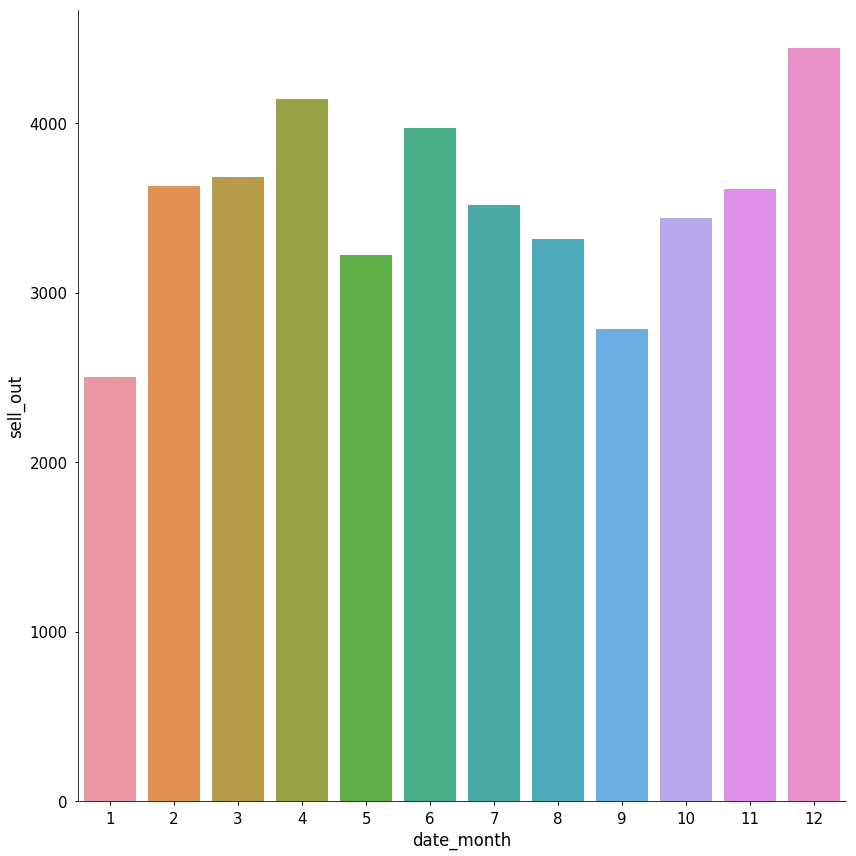

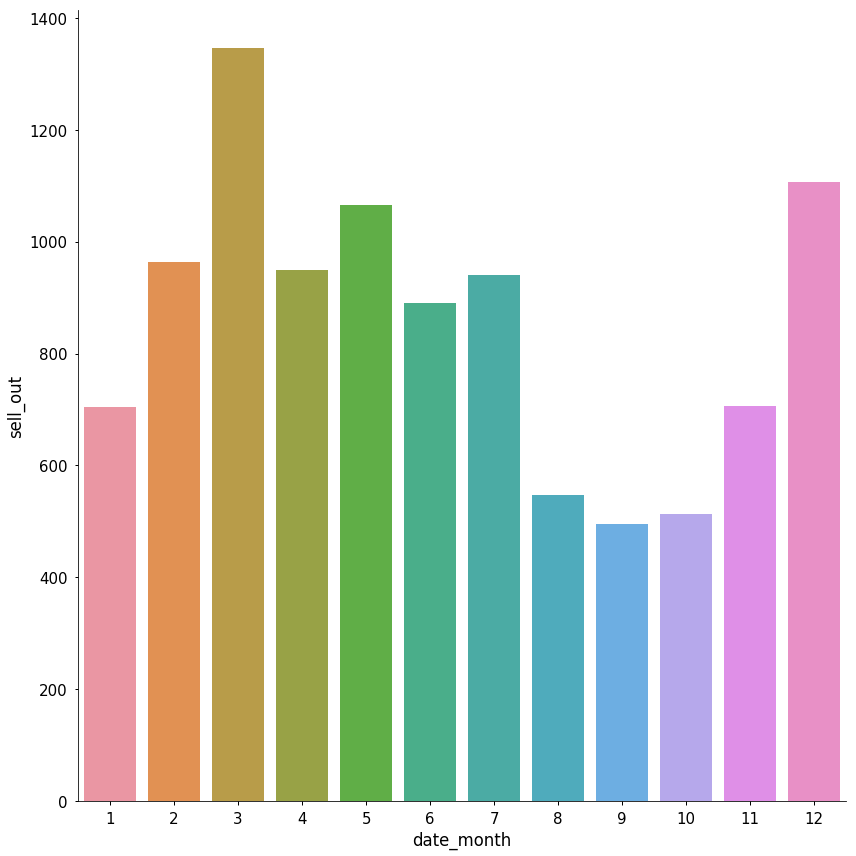

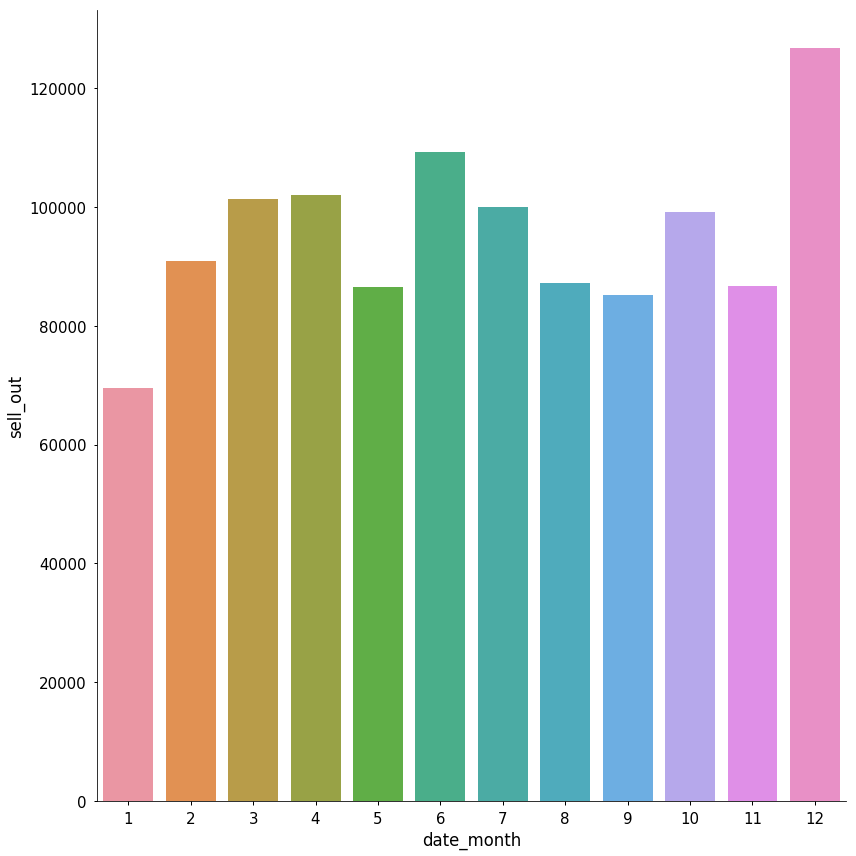

In [95]:
#Продажи по месяцам по продуктам
for k in item_vocab:
    y = data_a1[data_a1['item_id']==k].groupby('date_month',as_index = False)['sell_out'].sum()
    print(item_vocab[k])
    fig = sns.factorplot(x='date_month', y='sell_out', 
               data=y, kind='bar', size=12)
    fig.savefig('date_month.png', bbox_inches='tight')

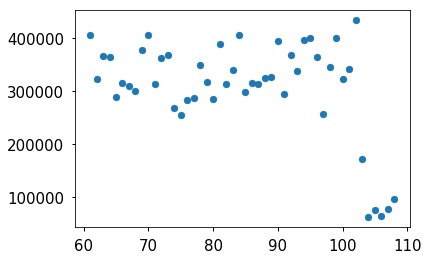

In [11]:
y = data_a1.groupby('date_month_long').sum()
plt.scatter(y.index, y['sell_out'])


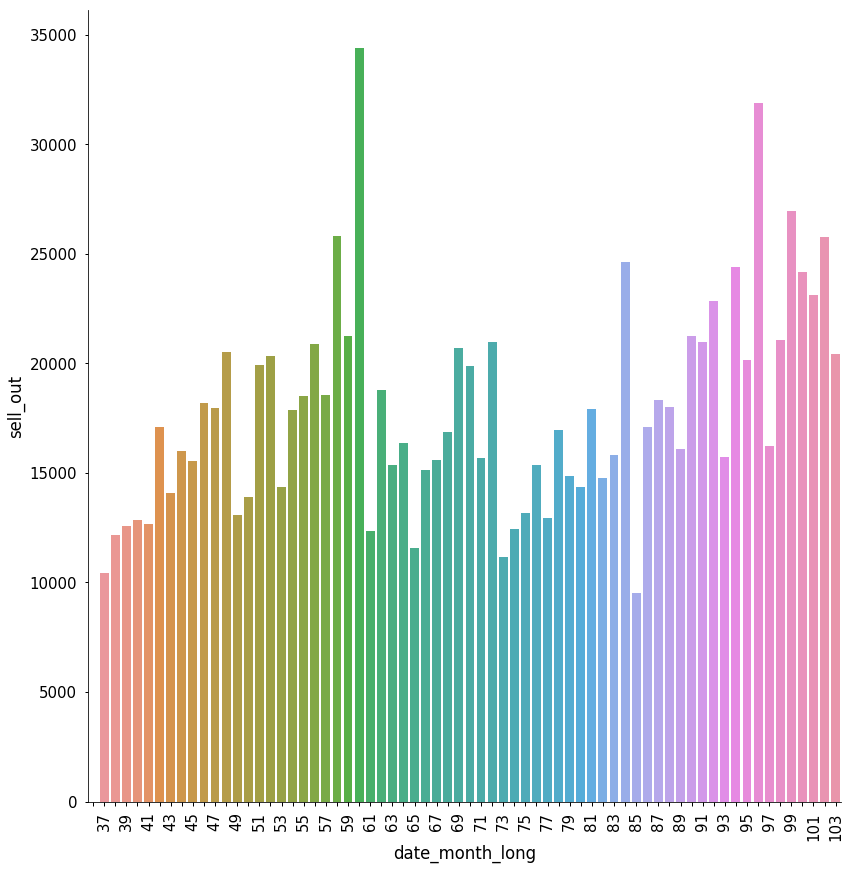

In [93]:
y = data_a1.groupby('date_month_long',as_index = False).sum()
fig = sns.factorplot(x='date_month_long', y='sell_out', 
               data=y, kind='bar', size=12)
#labels = ax.get_xticklabels() # get x labels

for ax in fig.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=90) # set new labels
fig.savefig('date_month_long.png', bbox_inches='tight')

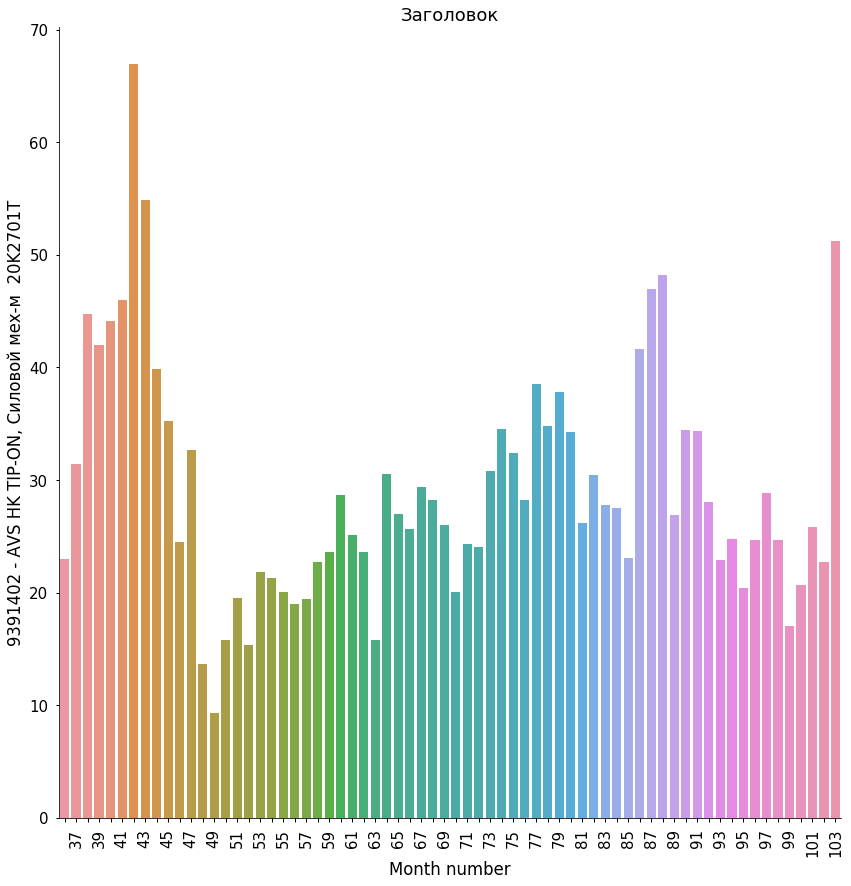

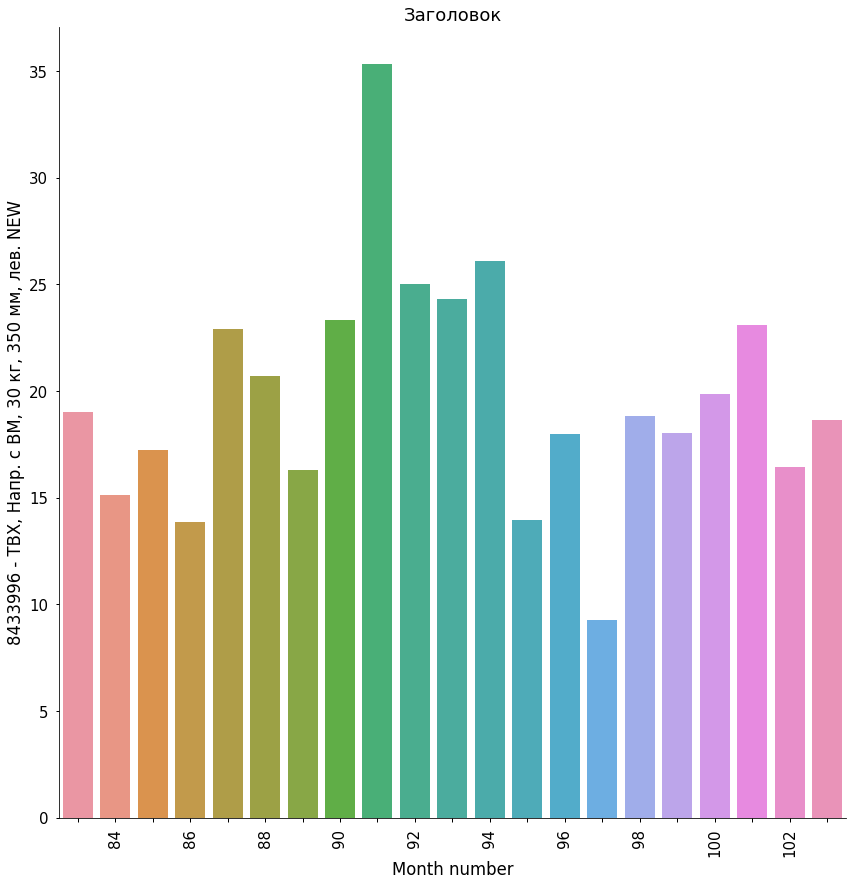

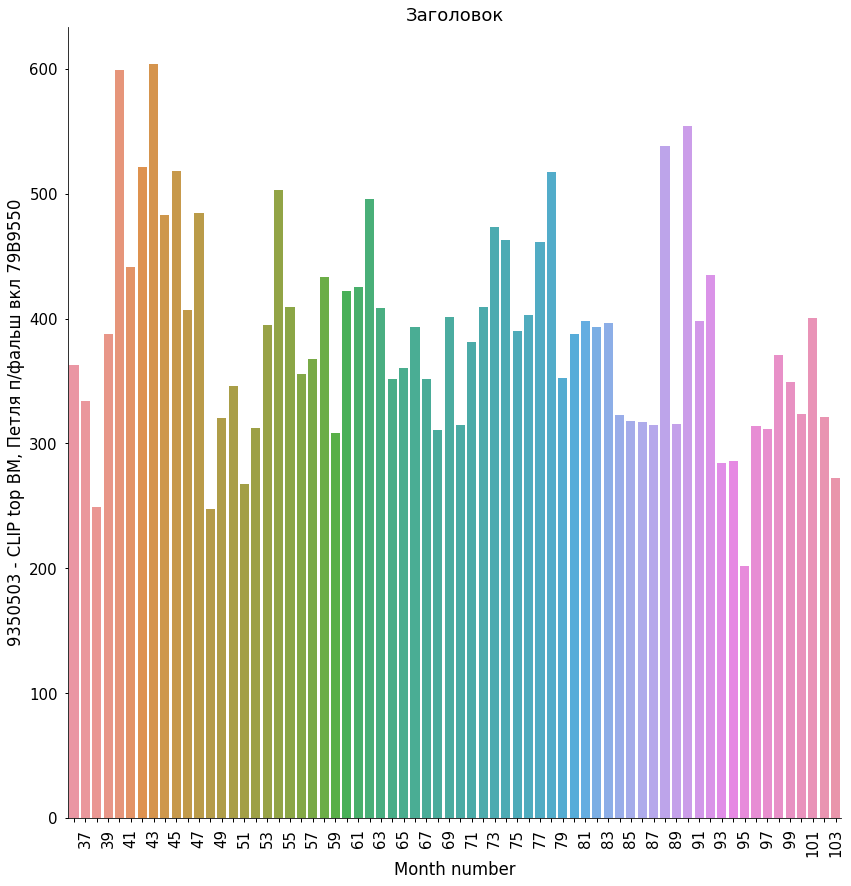

In [209]:
#rest items by house id
sel_h_id = 2100
for k in item_vocab:
    y = data_a1[(data_a1['item_id']==k)&(data_a1['house_id']==sel_h_id)].groupby('date_month_long',as_index = False)['rest'].mean()
    fig = sns.factorplot(x='date_month_long', y='rest', 
               data=y, kind='bar', size=12)
    fig.set_axis_labels("Month number", "%s - %s"%(k,item_vocab[k]))
    for ax in fig.axes.flat:
        labels = ax.get_xticklabels() # get x labels
        ax.set_title("Заголовок")
        for i,l in enumerate(labels):
            if(i%2 == 0): labels[i] = '' # skip even labels
        ax.set_xticklabels(labels, rotation=90) # set new labels
    fig.savefig('rest_by_month_2100_%s.png'%k, bbox_inches='tight')

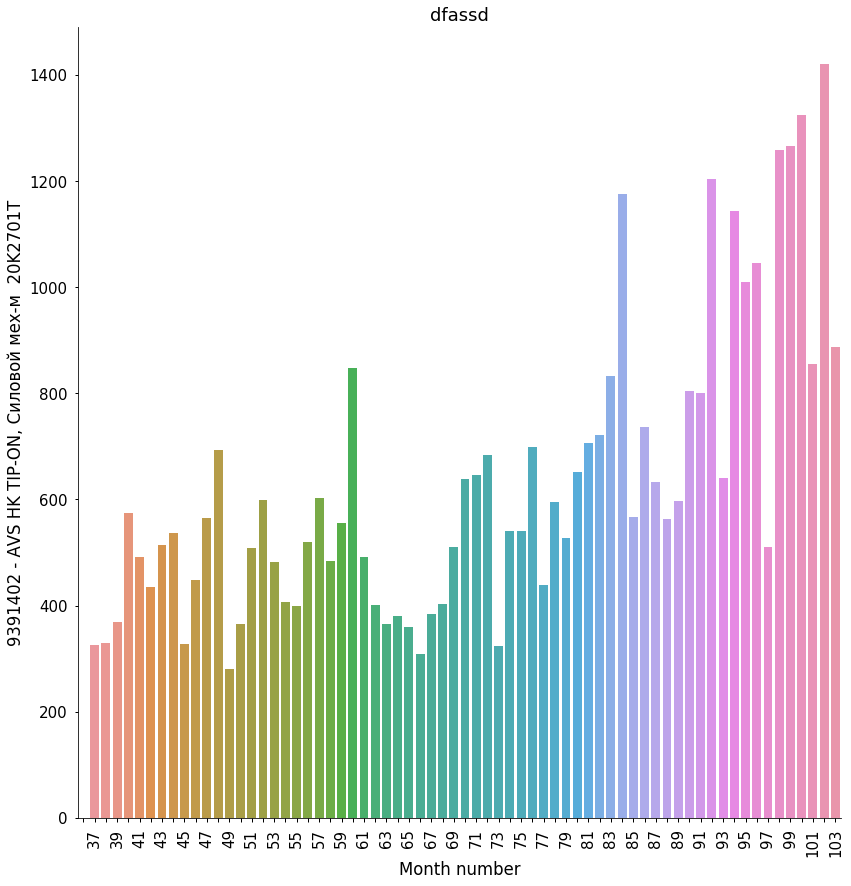

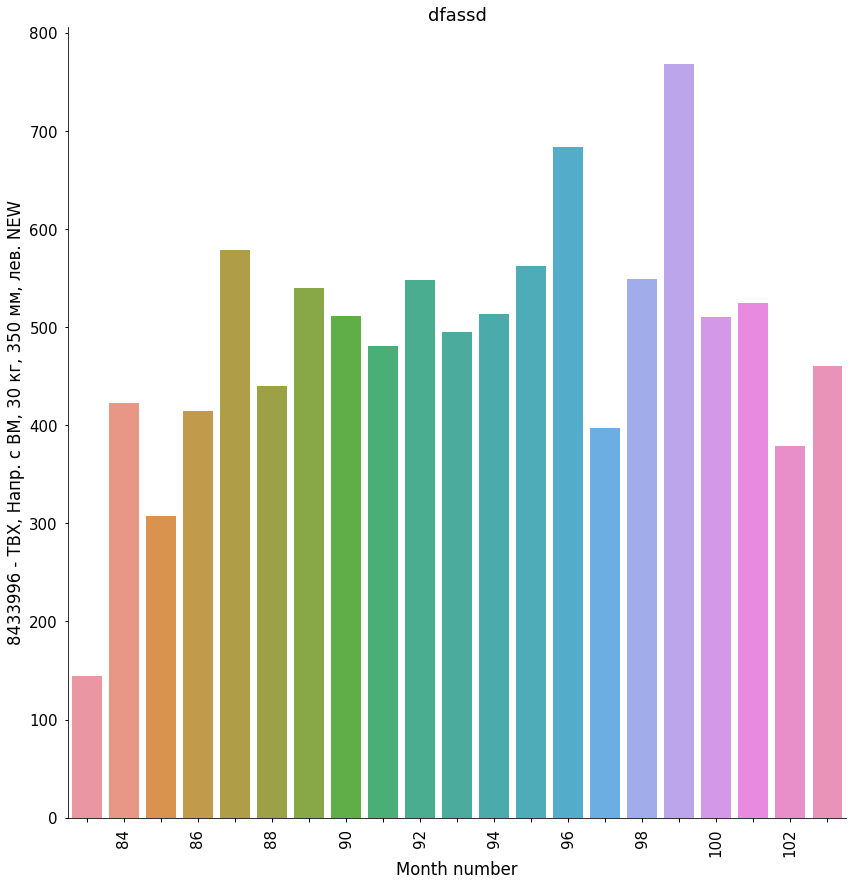

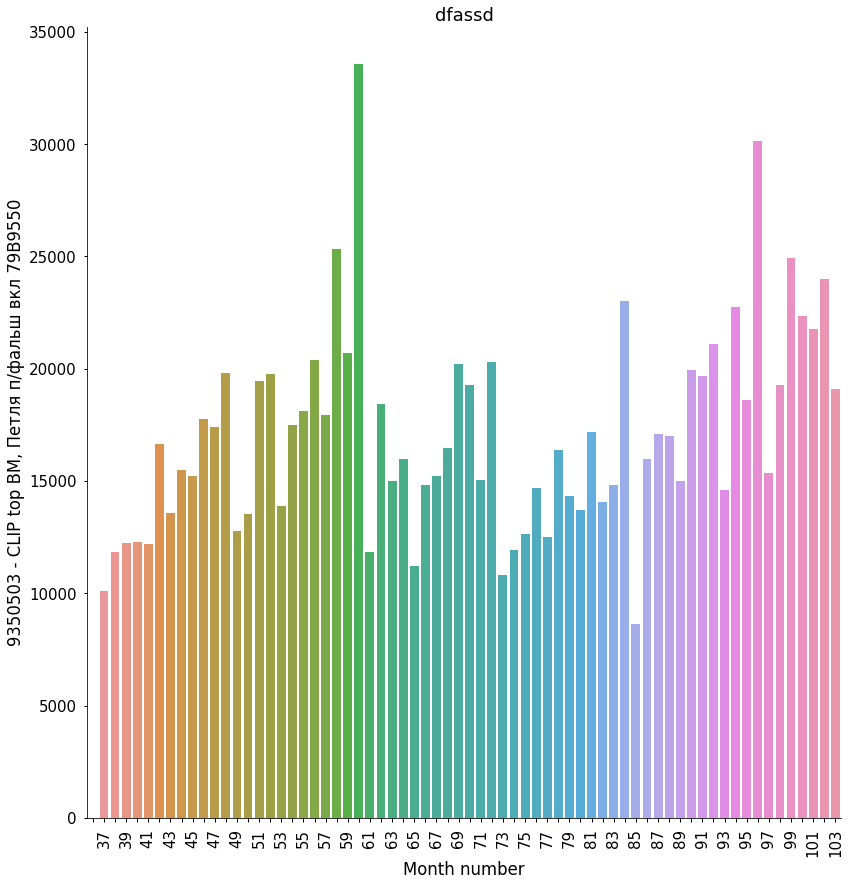

In [204]:
#sell_out by items
for k in item_vocab:
    y = data_a1[data_a1['item_id']==k].groupby('date_month_long',as_index = False)['sell_out'].sum()
    fig = sns.factorplot(x='date_month_long', y='sell_out', 
               data=y, kind='bar', size=12)
    fig.set_axis_labels("Month number", "%s - %s"%(k,item_vocab[k]))
    for ax in fig.axes.flat:
        labels = ax.get_xticklabels() # get x labels
        ax.set_title("Заголовок")
        for i,l in enumerate(labels):
            if(i%2 == 0): labels[i] = '' # skip even labels
        ax.set_xticklabels(labels, rotation=90) # set new labels
    fig.savefig('date_month_long_%s.png'%k, bbox_inches='tight')

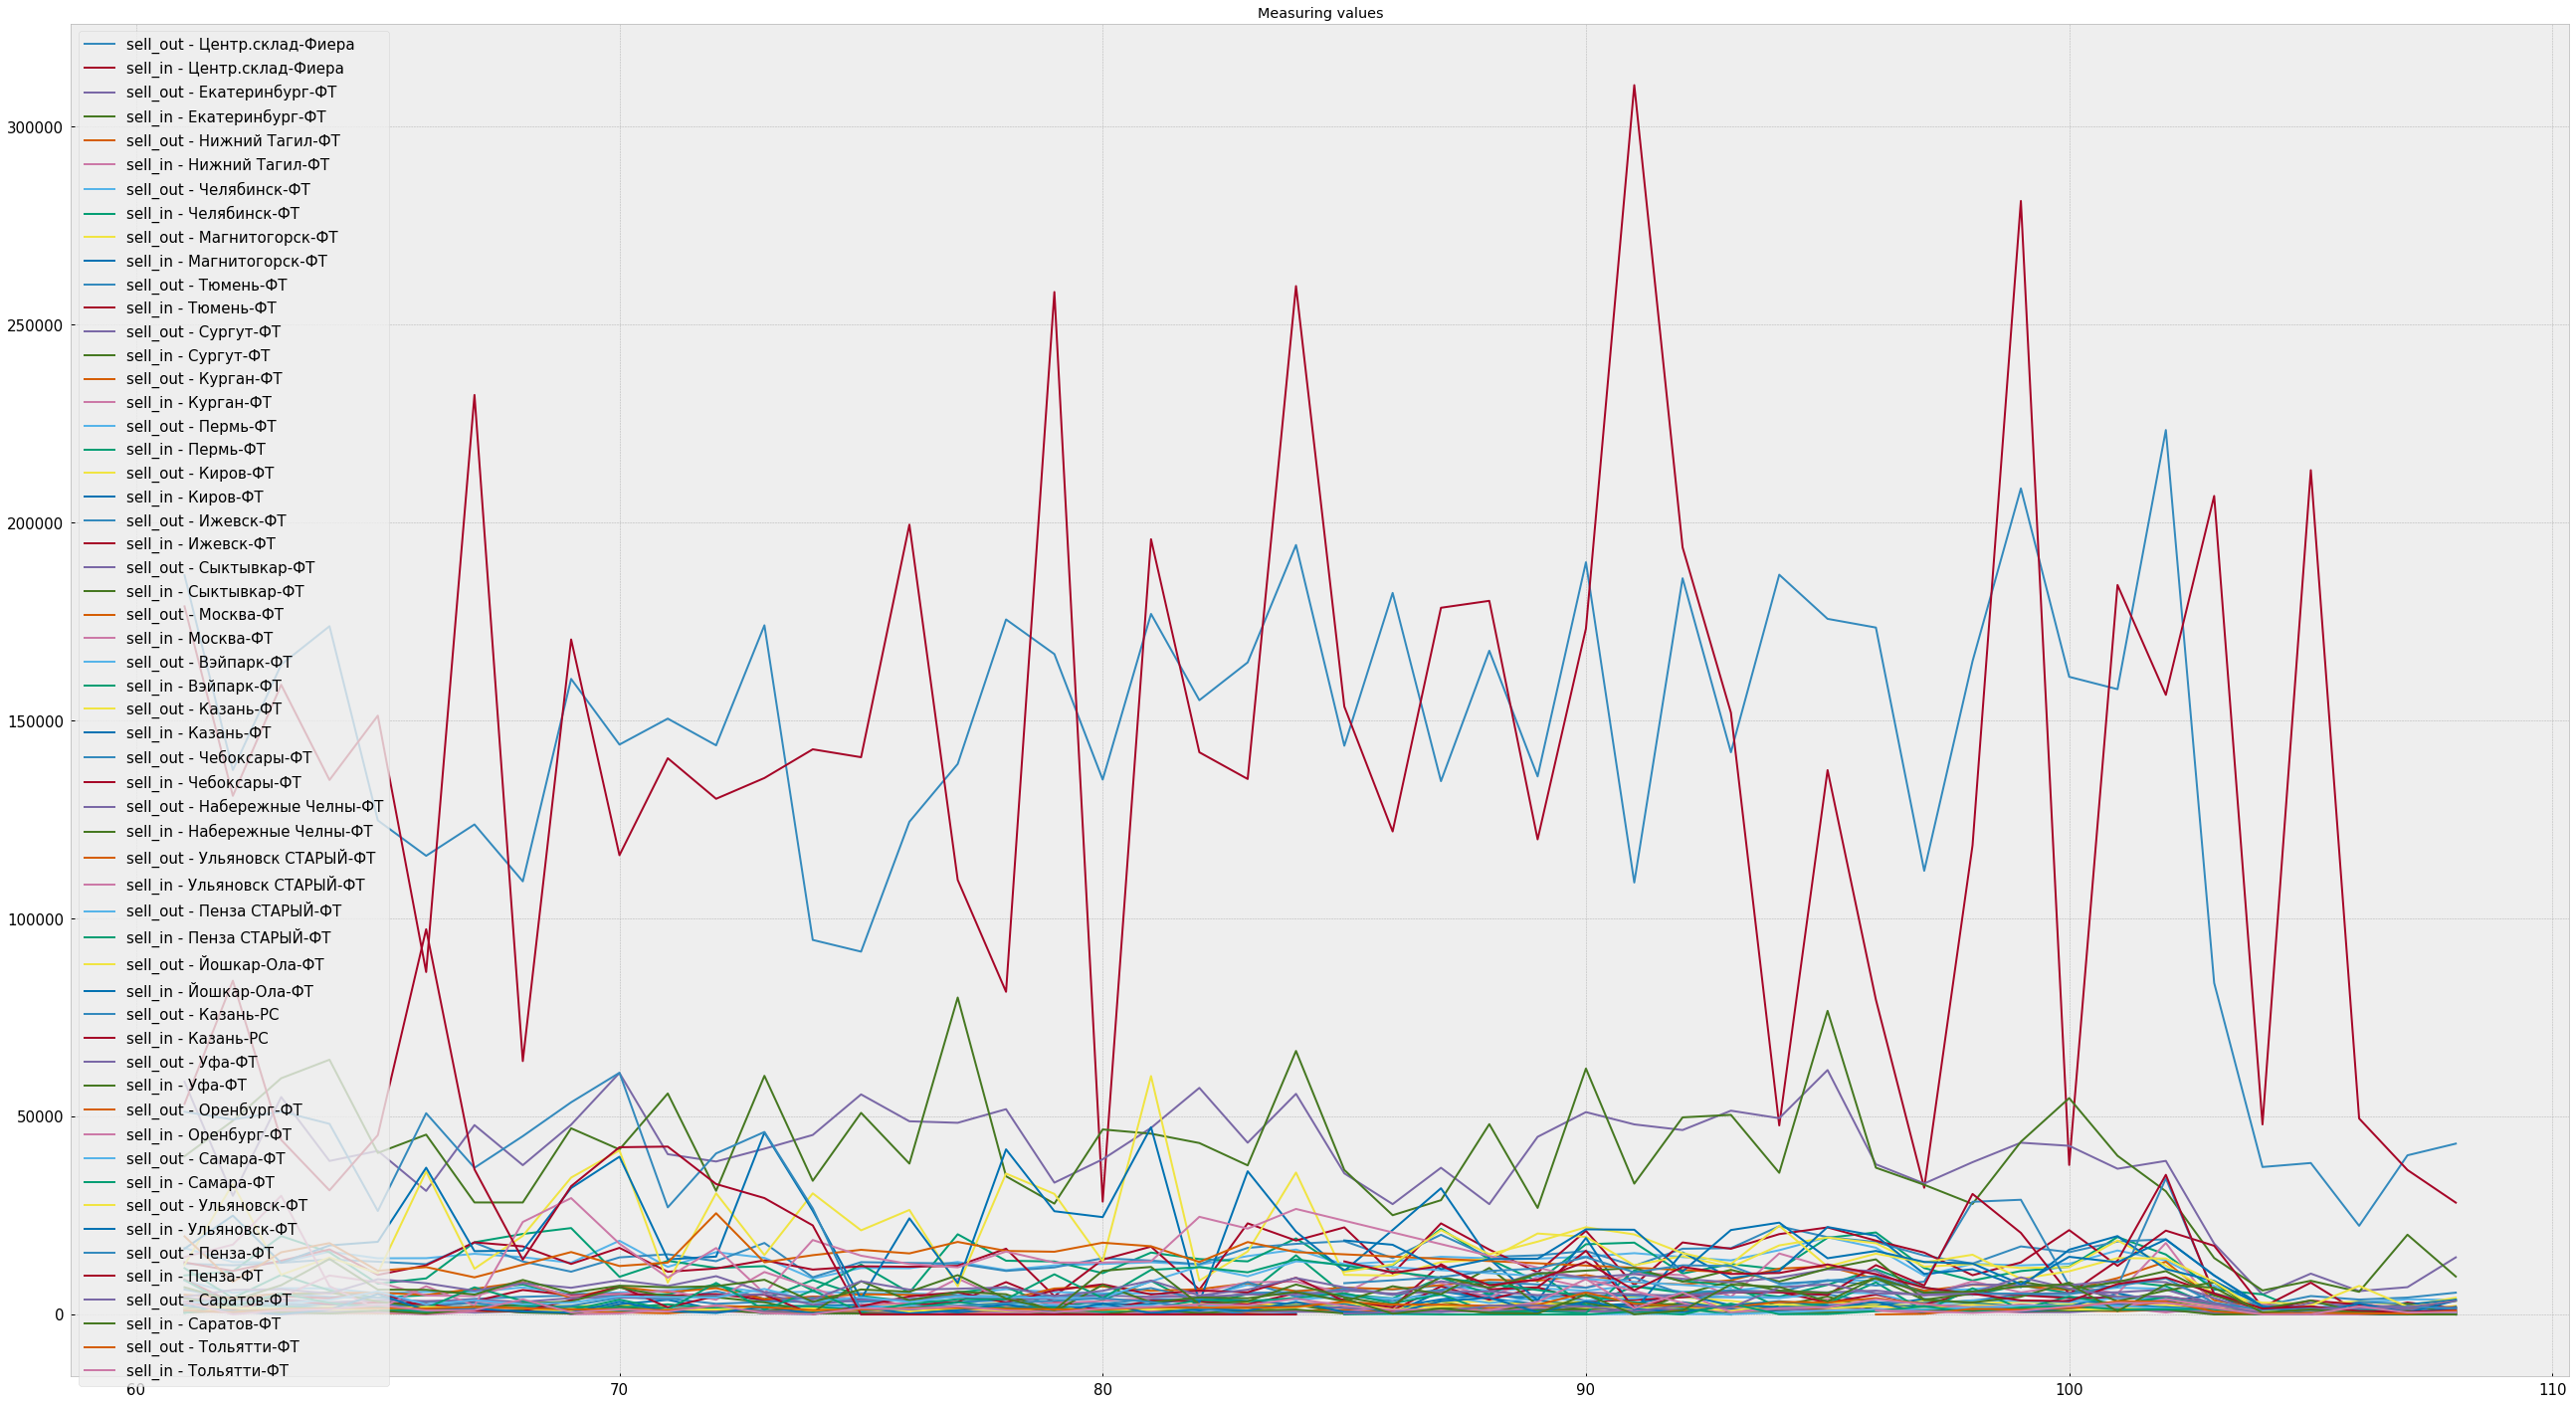

In [13]:
y = data_a1.groupby(['date_month_long','house_id'],as_index = False).sum()
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(45, 25))
    plt.title('Measuring values')
    for k in y['house_id'].unique():
        plt.plot(y[y['house_id']==k]['date_month_long'],y[y['house_id']==k]['sell_out'],label='sell_out - %s'%house_vocab[k])
        plt.plot(y[y['house_id']==k]['date_month_long'],y[y['house_id']==k]['sell_in'],label='sell_in - %s'%house_vocab[k])
    plt.legend(loc="best")
fig.savefig('date_month_long.house_id.png', bbox_inches='tight')
    

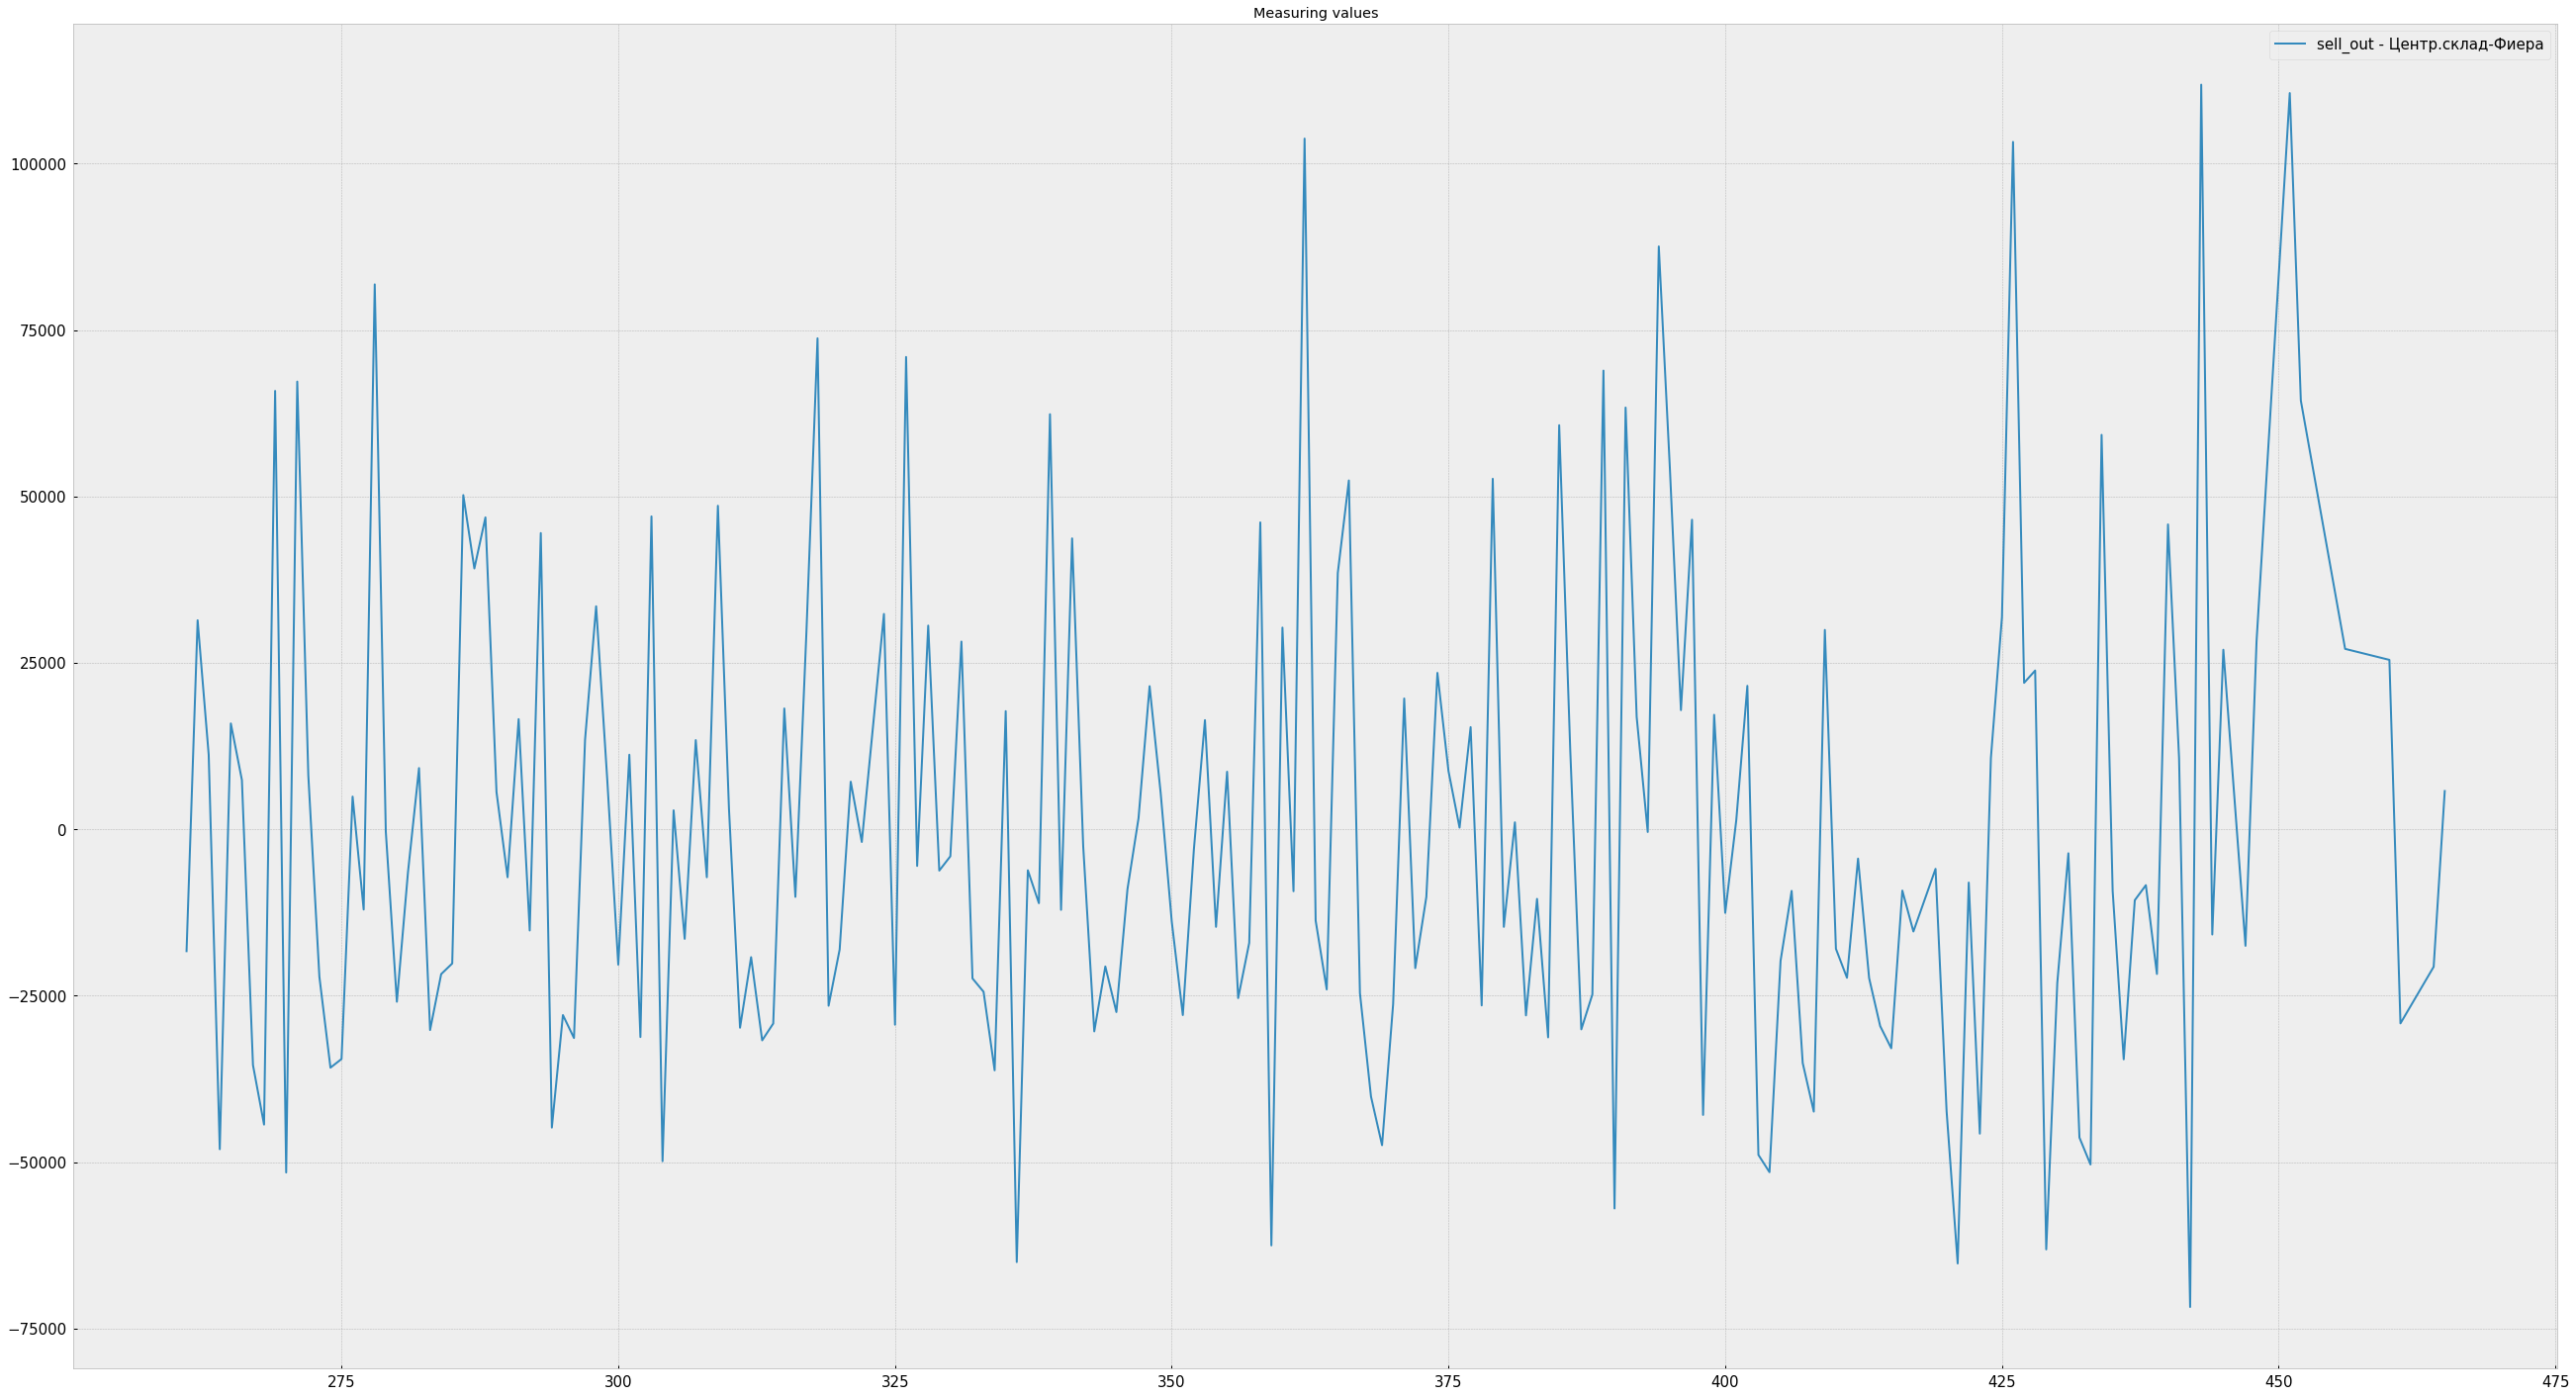

In [23]:
d_temp = data_a1[data_a1['house_id']==1100]
d_temp['sell_out'] = d_temp['sell_in']-d_temp['sell_out']
y = d_temp.groupby(['date_week_long','house_id'],as_index = False).sum()
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(45, 25))
    plt.title('Measuring values')
    for k in y['house_id'].unique():
        plt.plot(y[y['house_id']==k]['date_week_long'],y[y['house_id']==k]['sell_out'],label='sell_out - %s'%house_vocab[k])
        #plt.plot(y[y['house_id']==k]['date_month_long'],y[y['house_id']==k]['sell_in'],label='sell_in - %s'%house_vocab[k])
    plt.legend(loc="best")
fig.savefig('date_week_long.house_id.png', bbox_inches='tight')

In [14]:
y = data_a1.groupby(['date_month_long','house_id'],as_index = False).sum()
y[y['house_id']==2200].describe()

date_month_long  house_id       trans_id     sell_big       item_id  \
count            48.00      48.0      48.000000    48.000000  4.800000e+01   
mean             84.50    2200.0  616068.833333  -211.729167  5.483908e+09   
std              14.00       0.0  192936.587473  3955.129913  1.724471e+09   
min              61.00    2200.0  111642.000000 -9116.000000  9.188690e+08   
25%              72.75    2200.0  594920.000000 -2500.500000  5.309362e+09   
50%              84.50    2200.0  656356.000000  -218.500000  5.848781e+09   
75%              96.25    2200.0  719088.750000  2394.500000  6.355202e+09   
max             108.00    2200.0  897610.000000  8772.000000  8.025116e+09   

       date_dayweek    date_month     date_year      sell_out       sell_in  
count     48.000000     48.000000  4.800000e+01     48.000000     48.000000  
mean    2417.520833   6706.458333  2.083214e+06  12699.562500  12487.833333  
std      737.234250   4772.556917  6.525626e+05   4001.224759   5532.649726  
min      666.000000    878.000000  3.793840e+05   1556.000000     25.000000  
25%     2186.000000   2964.750000  2.019277e+06  12299.000000   9411.000000  
50%     2523.000000   5822.500000  2.217140e+06  13332.000000  12322.000000  
75%     2919.000000   9840.000000  2.432397e+06  14640.000000  16206.750000  
max     3595.000000  18072.000000  3.037602e+06  19513.000000  21828.000000

In [245]:
date1 = date(2010, 6, 25)
date2 = date(2010, 7, 2)
date_delta = abs(date1-date2)
date_delta.days//7
type(date1)

datetime.date